In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import re
import numpy

import matplotlib.pyplot as plt

In [4]:
from common.plotting import plot_mat

In [5]:
# From http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

Please note that the graph visualizations only work in Chrome :(

In [6]:
tf.reset_default_graph()

Network on MNIST

In [7]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [1.0 / 255.0, 0], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 25))
                                               
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 100))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 100))

Couldn't import dot_parser, loading of dot files will not be possible.


In [8]:
print("The streams return batches containing %s" % (mnist_train_stream.sources,))

print("Each trainin batch consits of a tuple containing:")
for element in next(mnist_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))
    
print("Validation/test batches consits of tuples containing:")
for element in next(mnist_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 1, 28, 28) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 1, 28, 28) containing float32
 - an array of size (100, 1) containing uint8


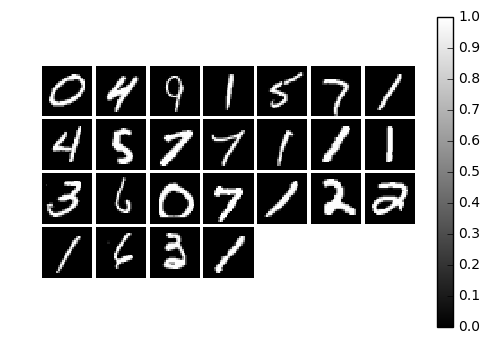

In [9]:
from common.plotting import plot_mat

mnist_X,mnist_Y= next(mnist_train_stream.get_epoch_iterator())

plot_mat(mnist_X, cmap='gray')
plt.colorbar()

In [10]:
def affine_layer(X, num_hidden, activation=None, name=None):
    name = name or "affine_layer"
    with tf.variable_scope(None, default_name=name):
        W = tf.get_variable('W', (X.shape[1].value, num_hidden), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', (1, num_hidden), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.matmul(X, W) + b
        if activation:
            Y = activation(Y)
        return Y


In [11]:
tf.reset_default_graph()

In [12]:
# X is batch_size x num_channels x width x heigth
X = tf.placeholder(shape=(None, 1, 28, 28), dtype=np.float32, name='X')
X_flat = tf.reshape(X, (-1, np.prod(X.shape.as_list()[1:])))
Y = tf.placeholder(shape=(None, 1), dtype=np.int32, name='Y')

In [13]:
# Hiperparams

latent_dim = 20

# Encoder 
Encoded = X_flat
Encoded = affine_layer(Encoded, 500, activation=tf.nn.relu)
Encoded = affine_layer(Encoded, 500, activation=tf.nn.relu)
Encoded = affine_layer(Encoded, latent_dim * 2, activation=None)

Z_mean, Z_log_sigma2 = tf.split(Encoded, 2, axis=1)

Epsilon = tf.random_normal(tf.shape(Z_mean)) 
Z = Epsilon * tf.exp(0.5 * Z_log_sigma2) + Z_mean
#Z = Z_mean

# Decoder - reconstruction
Decoded = Z
Decoded = affine_layer(Decoded, 500, activation=tf.nn.relu)
Decoded = affine_layer(Decoded, 500, activation=tf.nn.relu)
Decoded = affine_layer(Decoded, X_flat.shape[1].value, activation=None)

Reconstructed = tf.reshape(tf.nn.sigmoid(Decoded), [-1] + X.shape.as_list()[1:])

N = tf.cast(tf.shape(X_flat)[0], tf.float32)
latent_loss = (-0.5 / N) * (
    tf.reduce_sum(1.0 + Z_log_sigma2 - tf.square(Z_mean) - tf.exp(Z_log_sigma2)))

reconstruction_loss = (1.0 / N) * tf.reduce_sum(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=Decoded, targets=X_flat))

#per_example_reconstruction_loss = tf.reduce_sum(
#        tf.square(Decoded-X_flat), axis=1)


weight_decay_loss = tf.constant(0.0, dtype=tf.float32)
for V in tf.trainable_variables():
    if re.match(".*/W.*", V.name):
        print("Decaying %s" % (V.name, ))
        weight_decay_loss += 1.0e-5 * tf.reduce_sum(V**2)

batch_loss = (
    reconstruction_loss + 
    latent_loss +
    weight_decay_loss)

Decaying affine_layer/W:0
Decaying affine_layer_1/W:0
Decaying affine_layer_2/W:0
Decaying affine_layer_3/W:0
Decaying affine_layer_4/W:0
Decaying affine_layer_5/W:0


In [14]:
learning_rate = tf.get_variable('learning_rate', shape=(), dtype='float32', 
                              trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(batch_loss)
global_step = tf.get_variable('global_step', shape=(), dtype='int32', 
                              trainable=False)
train_op = tf.group(train_op, tf.assign_add(global_step, 1))
initialize_op = tf.global_variables_initializer()

In [15]:
# show_graph()

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(initialize_op)

train_loss_history = []
valid_loss_history = []
epoch = 0

In [17]:
sess.run(learning_rate.assign(1e-4))

9.9999997e-05

In [18]:
# train for a while
global_step_v = sess.run(global_step)

while global_step_v < 100000:
    epoch += 1
    for batch_X, batch_Y in mnist_train_stream.get_epoch_iterator():
        feed_dict = {X: batch_X, Y: batch_Y}
        (_, global_step_v, loss_v,
         weight_decay_loss_v, latent_loss_v, reconstruction_loss_v
        ) = sess.run([train_op, global_step, batch_loss,
                      weight_decay_loss, latent_loss, reconstruction_loss
                     ], feed_dict=feed_dict)
        if (global_step_v % 1000) == 1:
            train_loss_history.append((epoch, global_step_v, loss_v,))
            print ("epoch: %d, step: %d, loss: %g = %g(w) + %g(l) + %g(r)" % 
                   (epoch, global_step_v, loss_v,
                    weight_decay_loss_v, latent_loss_v, reconstruction_loss_v))

epoch: 1, step: 1, loss: 548.009 = 0.0233554(w) + 1.06787(l) + 546.917(r)
epoch: 1, step: 1001, loss: 152.623 = 0.0238023(w) + 11.7682(l) + 140.831(r)
epoch: 2, step: 2001, loss: 137.319 = 0.0251038(w) + 14.4808(l) + 122.813(r)
epoch: 2, step: 3001, loss: 129.557 = 0.026101(w) + 17.3126(l) + 112.218(r)
epoch: 3, step: 4001, loss: 134.936 = 0.0269999(w) + 19.9323(l) + 114.977(r)
epoch: 3, step: 5001, loss: 120.34 = 0.0277801(w) + 19.166(l) + 101.146(r)
epoch: 4, step: 6001, loss: 124.576 = 0.0284534(w) + 21.0845(l) + 103.464(r)
epoch: 4, step: 7001, loss: 119.117 = 0.0291186(w) + 22.178(l) + 96.9102(r)
epoch: 5, step: 8001, loss: 118.853 = 0.0297022(w) + 22.6309(l) + 96.192(r)
epoch: 5, step: 9001, loss: 108.622 = 0.0302482(w) + 22.3515(l) + 86.2407(r)
epoch: 6, step: 10001, loss: 124.953 = 0.0307415(w) + 24.2536(l) + 100.669(r)
epoch: 6, step: 11001, loss: 117.386 = 0.0311973(w) + 24.1896(l) + 93.1651(r)
epoch: 7, step: 12001, loss: 105.954 = 0.0316193(w) + 22.2888(l) + 83.6338(r)
epoc

KeyboardInterrupt: 

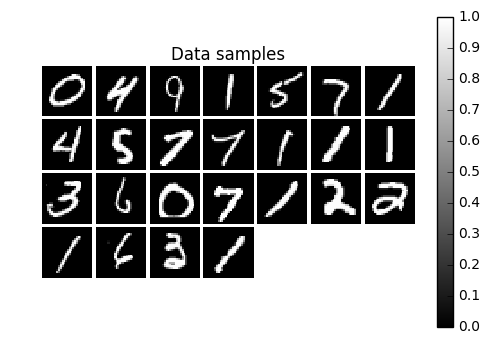

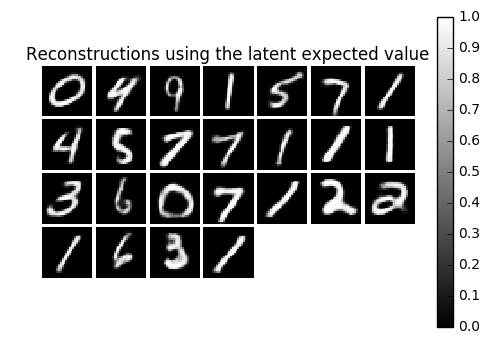

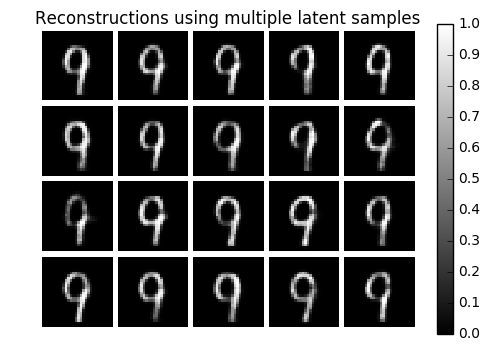

In [19]:
plot_mat(mnist_X, cmap='gray')
plt.colorbar()
plt.title('Data samples')

plt.figure()
plot_mat(sess.run(Reconstructed, 
                  feed_dict={X:mnist_X, 
                             Epsilon:np.zeros((mnist_X.shape[0], latent_dim), dtype='float32')}
                 ), cmap='gray')
plt.colorbar()
plt.title('Reconstructions using the latent expected value')

plt.figure()
plot_mat(sess.run(Reconstructed, 
                  feed_dict={X:np.vstack([mnist_X[2:3,...]]*20)}
                 ), cmap='gray')
plt.colorbar()
plt.title('Reconstructions using multiple latent samples')

In [ ]:
if latent_dim == 2:
    Z_mesh_x, Z_mesh_y = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
    Z_mesh = np.concatenate([Z_mesh_x.reshape(-1, 1), 
                             Z_mesh_y.reshape(-1, 1)], axis=1)

    Mesh = sess.run(Reconstructed, feed_dict={Z: Z_mesh})
    plot_mat(Mesh, prop=(1,1), cmap='gray')